In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 10
%matplotlib inline

In [3]:
full_meteo = pd.read_csv("./formatted_data/full_meteo.csv")
full_meteo.index = pd.to_datetime(full_meteo["DATE"])
full_meteo.head()

,DATE,MAX_TEMP,DAY,YEAR
DATE,,,,
1975-01-01,1975-01-01,8.1,01-01,1975
1975-01-02,1975-01-02,3.2,01-02,1975
1975-01-03,1975-01-03,4.5,01-03,1975
1975-01-04,1975-01-04,6.4,01-04,1975
1975-01-05,1975-01-05,7.0,01-05,1975


In [4]:
from statsmodels.tsa.stattools import adfuller
import pdb
def test_stationarity(timeseries):    
    # Determing rolling statistics  
    rolmean = timeseries.rolling(window=365).mean()
    # Plot rolling statistics:  
    fig = plt.figure(1, figsize=(20, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')  
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')  
    plt.legend(loc='best')  
    plt.title('Rolling Mean')  
    plt.show(block=False)    
    # Perform Augmented Dickey-Fuller test:  
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])  
    for key,value in dftest[4].items():    
        dfoutput['Critical Value (%s)'%key] = value  
    print(dfoutput)

/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


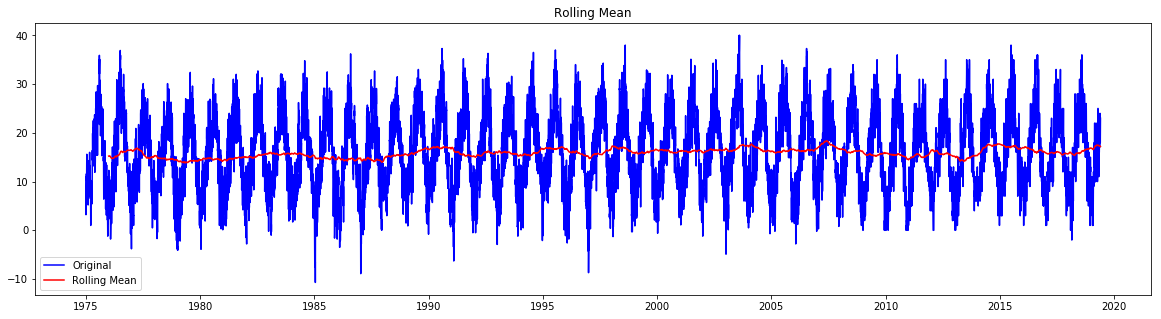

Results of Augmented Dickey-Fuller test:
Test Statistic                -8.861958e+00
p-value                        1.474659e-14
#Lags Used                     4.300000e+01
Number of Observations Used    1.617800e+04
Critical Value (1%)           -3.430754e+00
Critical Value (5%)           -2.861719e+00
Critical Value (10%)          -2.566865e+00
dtype: float64


In [5]:
test_stationarity(full_meteo["MAX_TEMP"])

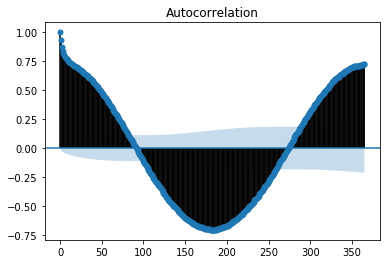

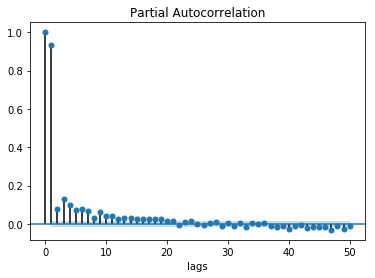

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_acf(full_meteo["MAX_TEMP"], lags=365)
plot_pacf(full_meteo["MAX_TEMP"], lags=50)
plt.xlabel('lags')
plt.show()

In [7]:
test = [full_meteo.index[i] - full_meteo.index[i-1] for i in range(1, len(full_meteo))]

In [8]:
from datetime import datetime, timedelta
for i in range(1, len(full_meteo)):
    if full_meteo.index[i] - full_meteo.index[i-1] > timedelta(days=1):
        print(full_meteo.index[i-1], full_meteo.index[i])

In [9]:
from statsmodels.tsa.arima_model import ARMA

import itertools
p = q = range(0, 3)
pq = itertools.product(p, q)
for param in pq:  
    try:    
        mod = ARMA(full_meteo["MAX_TEMP"], order=param, freq="D")    
        results = mod.fit()    
        print('ARMA{} - AIC:{}'.format(param, results.aic))  
    except Exception as e:
        print(e)
        continue

/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


ARMA(0, 0) - AIC:112321.35500420946
ARMA(0, 1) - AIC:97721.97957565964
ARMA(0, 2) - AIC:90628.05827399425
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ARMA(1, 0) - AIC:79642.45276006917
ARMA(1, 1) - AIC:79506.70269792681
ARMA(1, 2) - AIC:79068.83313425038
ARMA(1, 3) - AIC:78827.54525485777
ARMA(2, 0) - AIC:79547.55095507743
ARMA(2, 1) - AIC:78702.2450461486
ARMA(2, 2) - AIC:78656.53009465063
ARMA(2, 3) - AIC:78657.96451388688
ARMA(3, 0) - AIC:79269.17752286834
ARMA(3, 1) - AIC:78657.94020401186
ARMA(3, 2) - AIC:78658.1126076706
ARMA(3, 3) - AIC:78659.80699782676


/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


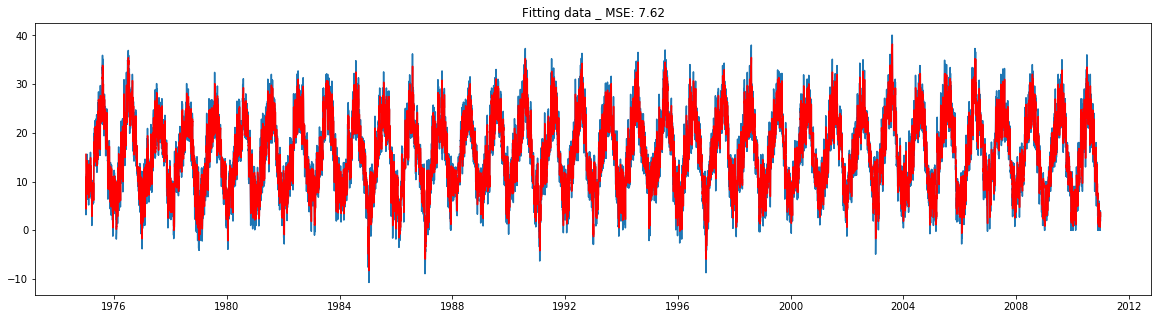

In [10]:
model = ARMA(full_meteo[full_meteo["YEAR"] <= 2010]["MAX_TEMP"], order=(2,3))
results_MA = model.fit()
fig = plt.figure(1, figsize=(20, 5))
plt.plot(full_meteo[full_meteo["YEAR"] <= 2010]["MAX_TEMP"])
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-full_meteo["MAX_TEMP"])**2).mean()))
plt.show()

In [23]:
predictions, std_err, conf_int = results_MA.forecast(steps=len(full_meteo[full_meteo["YEAR"] > 2010]))

In [24]:
predictions

array([ 2.23527213,  2.47966189,  2.65986066, ..., 15.58037299,
       15.58037299, 15.58037299])

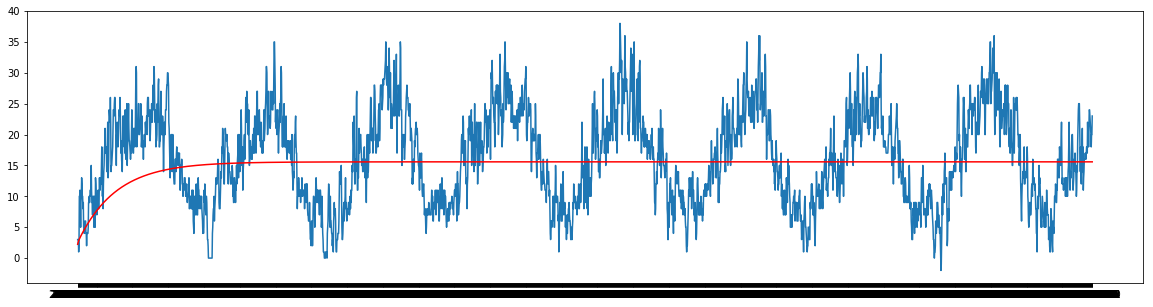

In [27]:
fig = plt.figure(1, figsize=(20, 5))
plt.plot(full_meteo[full_meteo["YEAR"] > 2010]["DATE"], full_meteo[full_meteo["YEAR"] > 2010]["MAX_TEMP"])
plt.plot(full_meteo[full_meteo["YEAR"] > 2010]["DATE"], predictions, color='red')
plt.show()

In [14]:
help(results_MA.forecast)

Help on method forecast in module statsmodels.tsa.arima_model:

forecast(steps=1, exog=None, alpha=0.05) method of statsmodels.tsa.arima_model.ARMAResults instance
    Out-of-sample forecasts
    
    Parameters
    ----------
    steps : int
        The number of out of sample forecasts from the end of the
        sample.
    exog : array
        If the model is an ARMAX, you must provide out of sample
        values for the exogenous variables. This should not include
        the constant.
    alpha : float
        The confidence intervals for the forecasts are (1 - alpha) %
    
    Returns
    -------
    forecast : array
        Array of out of sample forecasts
    stderr : array
        Array of the standard error of the forecasts.
    conf_int : array
        2d array of the confidence interval for the forecast



In [13]:
dir(ARMA)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fit_start_params',
 '_fit_start_params_hr',
 '_get_exog_names',
 '_get_index_label_loc',
 '_get_index_loc',
 '_get_init_kwds',
 '_get_prediction_index',
 '_handle_data',
 '_init_dates',
 '_invtransparams',
 '_set_exog_names',
 '_transparams',
 'endog_names',
 'exog_names',
 'fit',
 'from_formula',
 'geterrors',
 'hessian',
 'information',
 'initialize',
 'loglike',
 'loglike_css',
 'loglike_kalman',
 'predict',
 'score']